In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import wbgapi as wb
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler

## Clustering

In [2]:
country_codes = ['JOR','IRQ']
ind1=["EN.URB.LCTY"]
ind1m=["Population in Largest City"]
ind2=["NY.GDP.MKTP.CD"]
ind2m=["GDP"]

In [3]:
my_data1  = wb.data.DataFrame(ind1, country_codes, mrv=50).T
my_data2  = wb.data.DataFrame(ind2, country_codes, mrv=50).T

In [4]:
my_data1.head()

economy,IRQ,JOR
YR1972,2274661.0,429336.0
YR1973,2384330.0,451672.0
YR1974,2499449.0,475202.0
YR1975,2620127.0,499958.0
YR1976,2746809.0,526041.0


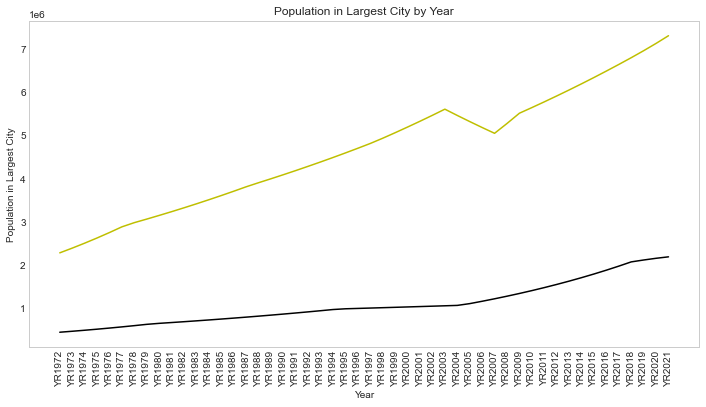

In [5]:
plt.figure(figsize=(12,6))
plt.title('Population in Largest City by Year')
plt.plot(my_data1['IRQ'],"y")
plt.plot(my_data1['JOR'],"k")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Population in Largest City")
plt.grid()
plt.show()

In [6]:
my_data2=my_data2.fillna(my_data2.mean())
my_data2.head()

economy,IRQ,JOR
YR1971,3.865347e+09,6.782414e+08
YR1972,4.113848e+09,7.885746e+08
YR1973,5.134368e+09,9.437005e+08
YR1974,1.151676e+10,1.197454e+09
YR1975,1.345852e+10,1.363039e+09


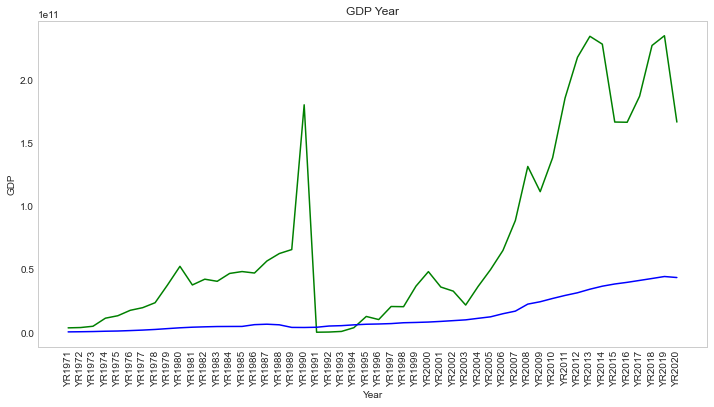

In [7]:
plt.figure(figsize=(12,6))
plt.title('GDP Year')
plt.plot(my_data2['IRQ'],"g")
plt.plot(my_data2['JOR'],"b")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("GDP")
plt.grid()
plt.show()

In [8]:
def normaliz(data):
    ssc=StandardScaler()
    norml=ssc.fit_transform(data)
    return norml
norml=normaliz(my_data1.values)

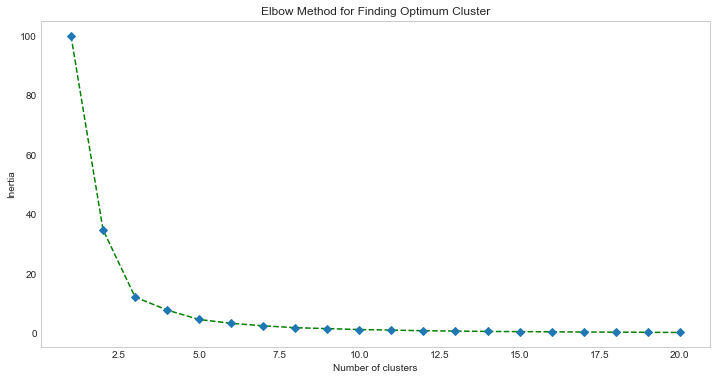

In [9]:
elb = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,  random_state=0)
    kmeans.fit(norml)
    elb.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.title('Elbow Method for Finding Optimum Cluster')
plt.plot(range(1, 21), elb,"g--")
plt.plot(range(1, 21), elb,"D")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [10]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit(norml)
pred_y

KMeans(n_clusters=5, random_state=0)

In [11]:
kmeans.cluster_centers_

array([[-0.53010594, -0.53928607],
       [ 1.64142471,  2.03017597],
       [ 0.92530783,  0.97251312],
       [ 0.35154982, -0.03804758],
       [-1.35328447, -1.08950442]])

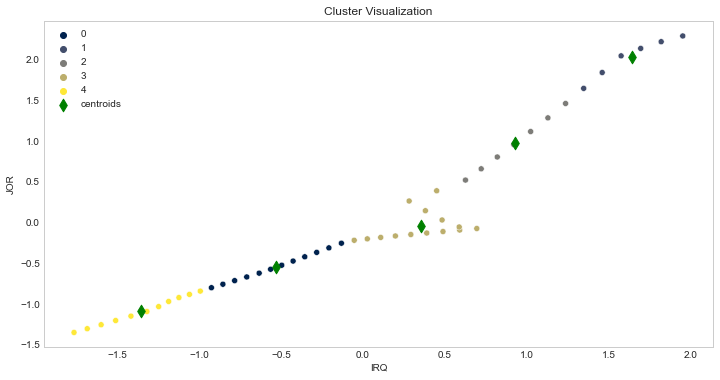

In [12]:
df=pd.DataFrame(norml,columns=my_data1.columns)
plt.figure(figsize=(12,6))
plt.title('Cluster Visualization')
sns.scatterplot(data=df, x="IRQ", y="JOR", hue=kmeans.labels_,palette="cividis")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="d", c="g", s=80, label="centroids")
plt.grid()
plt.legend()
plt.show()

## Curve Fitting

In [13]:
from scipy.optimize import curve_fit
#!pip install lmfit
from lmfit import Model

In [14]:
def exponential(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

In [15]:
norml2 =normaliz(my_data2.values)

y = exponential(norml2[:,1], 1.91, 0.7, 1.22) + np.random.normal(0, 0.2, norml2.shape[0])

init_vals = [1, 0, 1] 
best_vals, covar = curve_fit(exponential, norml2[:,1], y, p0=init_vals)
exp_model = Model(exponential)

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 50
    # variables        = 3
    chi-square         = 1.53107408
    reduced chi-square = 0.03257604
    Akaike info crit   = -168.302675
    Bayesian info crit = -162.566606
[[Variables]]
    amp:  1.96077356 +/- 0.08276681 (4.22%) (init = 5)
    cen:  0.73960606 +/- 0.02871743 (3.88%) (init = 5)
    wid:  1.17886337 +/- 0.07804892 (6.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.650
    C(cen, wid) = 0.487
    C(amp, cen) = -0.152


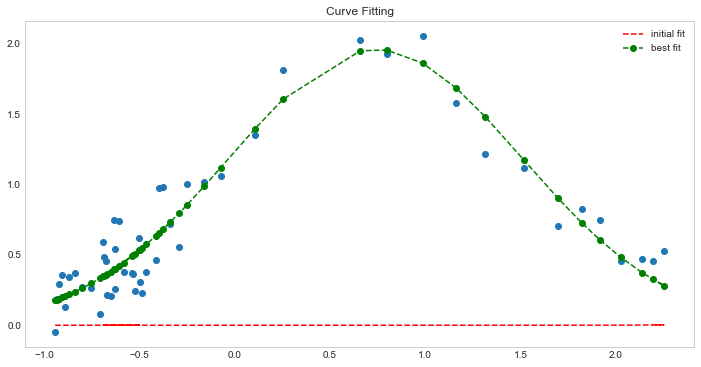

In [16]:
result = exp_model.fit(y, x=norml2[:,1], amp=5, cen=5, wid=1)

print(result.fit_report())

plt.figure(figsize=(12,6))
plt.title('Curve Fitting')
plt.plot(norml2[:,1],y, 'o')
plt.plot(norml2[:,1], result.init_fit, 'r--', label='initial fit')
plt.plot(norml2[:,1], result.best_fit, 'go--', label='best fit')
plt.legend()
plt.grid()
plt.show()